# This Notebook contains the Model training part

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import cv2
import random
import numpy as np
import pickle
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Model 1 (Using MobileNetV2) (Dataset - 10,000 frames)

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import numpy as np
import os

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load CSV file containing frame paths and labels
csv_path = "/content/drive/MyDrive/FOR_DATASET_0/labels_3.csv"
df = pd.read_csv(csv_path)

desired_size = 10000
df_reduced = df.groupby("label", group_keys=False).apply(
    lambda x: x.sample(int(desired_size * len(x) / len(df)), random_state=101)
)

# Split data into training and validation sets
train_df, temp_df = train_test_split(df_reduced, test_size=0.2, stratify=df_reduced["label"], random_state=101)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=101)

# Convert label column to strings
train_df["label"] = train_df["label"].astype(str)
val_df["label"] = val_df["label"].astype(str)
test_df["label"] = test_df["label"].astype(str)

# Ensure ImageDataGenerators are properly defined
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Define ImageDataGenerators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="frame_path",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary"
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col="frame_path",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary"
)

print("Training Labels Distribution:")
print(train_df["label"].value_counts())

print("\nValidation Labels Distribution:")
print(val_df["label"].value_counts())

print("\nTest Labels Distribution:")
print(test_df["label"].value_counts())

<ipython-input-7-929080e2e7d1>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_reduced = df.groupby("label", group_keys=False).apply(


Found 7999 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Training Labels Distribution:
label
1    4077
0    3922
Name: count, dtype: int64

Validation Labels Distribution:
label
1    510
0    490
Name: count, dtype: int64

Test Labels Distribution:
label
1    510
0    490
Name: count, dtype: int64


In [ ]:
# Load the MobileNetV2 model with pre-trained weights
base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freeze the base model
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
output = Dense(1, activation="sigmoid")(x)  # Binary classification

model0 = Model(inputs=base_model.input, outputs=output)

<ipython-input-9-fc3524a9780e>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))


In [ ]:
# Compile the model
model0.compile(optimizer=Adam(learning_rate=0.002), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
# Early stopping and checkpointing
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_model_3.keras",  # Change the extension to `.keras`
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

# Train the model
history = model0.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5530 - loss: 0.7428
Epoch 1: val_accuracy improved from -inf to 0.62100, saving model to best_model_3.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 1898s 7s/step - accuracy: 0.5531 - loss: 0.7426 - val_accuracy: 0.6210 - val_loss: 0.6442
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6345 - loss: 0.6380
Epoch 2: val_accuracy improved from 0.62100 to 0.65400, saving model to best_model_3.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 436s 2s/step - accuracy: 0.6345 - loss: 0.6380 - val_accuracy: 0.6540 - val_loss: 0.5936
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6766 - loss: 0.5884
Epoch 3: val_accuracy improved from 0.65400 to 0.68400, saving model to best_model_3.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 560s 2s/step - accuracy: 0.6766 - loss: 0.5884 - val_accuracy: 0.6840 - val_loss: 0.5823
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6775 - loss: 0.5678
Epoch 4: val_accuracy improved from 0.68400 to

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:-20]:  # Keep earlier layers frozen
    layer.trainable = False

In [ ]:
model0.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history_finetune = model0.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6701 - loss: 0.6278
Epoch 1: val_accuracy improved from 0.69700 to 0.70500, saving model to best_model_3.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 514s 2s/step - accuracy: 0.6702 - loss: 0.6275 - val_accuracy: 0.7050 - val_loss: 0.6001
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7459 - loss: 0.4504
Epoch 2: val_accuracy improved from 0.70500 to 0.72900, saving model to best_model_3.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 596s 2s/step - accuracy: 0.7459 - loss: 0.4503 - val_accuracy: 0.7290 - val_loss: 0.6358
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7763 - loss: 0.4092
Epoch 3: val_accuracy did not improve from 0.72900
250/250 ━━━━━━━━━━━━━━━━━━━━ 539s 2s/step - accuracy: 0.7763 - loss: 0.4092 - val_accuracy: 0.6880 - val_loss: 1.5618


In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col="frame_path",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary"
)

Found 1000 validated image filenames belonging to 2 classes.


In [ ]:
test_loss, test_accuracy = model0.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 143s 5s/step - accuracy: 0.7177 - loss: 0.5937
Test Loss: 0.597319483757019
Test Accuracy: 0.7049999833106995


In [ ]:
MODEL_SAVE_PATH = '/content/drive/MyDrive/FOR_DATASET_0/deepfake_detector_model_3.h5'
model0.save(MODEL_SAVE_PATH)
print(f"Model saved at {MODEL_SAVE_PATH}")

Model saved at /content/drive/MyDrive/FOR_DATASET_0/deepfake_detector_model_3.h5


In [ ]:
import tensorflow as tf

# ... your existing code ...

# Convert the Keras model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model0)
tflite_model = converter.convert()

# Save the TensorFlow Lite model
TFLITE_MODEL_PATH = '/content/drive/MyDrive/FOR_DATASET_0/deepfake_detector_model_3.tflite'
with open(TFLITE_MODEL_PATH, 'wb') as f:
    f.write(tflite_model)
print(f"TFLite model saved at {TFLITE_MODEL_PATH}")

Saved artifact at '/tmp/tmpqadgaks1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_159')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  137889131868608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137888783812384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137888783811152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137889132281552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137888783810976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137889351835968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137888783818544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137888783821184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137888783817136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137888783819072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1378887838

## Model 1 (Using EfficientNet) (Dataset - 10,000 frames)

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [13]:
# Load CSV file containing frame paths and labels
csv_path = "/content/drive/MyDrive/FOR_DATASET_0/labels_3.csv"
df = pd.read_csv(csv_path)

desired_size = 10000
df_reduced = df.groupby("label", group_keys=False).apply(
    lambda x: x.sample(int(desired_size * len(x) / len(df)), random_state=101)
)

# Split data into training and validation sets
train_df, temp_df = train_test_split(df_reduced, test_size=0.2, stratify=df_reduced["label"], random_state=101)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=101)

<ipython-input-13-465b174a904d>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_reduced = df.groupby("label", group_keys=False).apply(


In [14]:
# Convert label column to strings
train_df["label"] = train_df["label"].astype(str)
val_df["label"] = val_df["label"].astype(str)
test_df["label"] = test_df["label"].astype(str)

In [15]:
# Ensure ImageDataGenerators are properly defined
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Define ImageDataGenerators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="frame_path",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary"
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col="frame_path",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary"
)

Found 7999 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


In [16]:
print("Training Labels Distribution:")
print(train_df["label"].value_counts())

print("\nValidation Labels Distribution:")
print(val_df["label"].value_counts())

print("\nTest Labels Distribution:")
print(test_df["label"].value_counts())

Training Labels Distribution:
label
1    4077
0    3922
Name: count, dtype: int64

Validation Labels Distribution:
label
1    510
0    490
Name: count, dtype: int64

Test Labels Distribution:
label
1    510
0    490
Name: count, dtype: int64


In [17]:
# Load the EfficientNetB0 model with pre-trained weights
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

In [18]:
# Freeze the base model
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
output = Dense(1, activation="sigmoid")(x)  # Binary classification

model = Model(inputs=base_model.input, outputs=output)

In [19]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.002), loss="binary_crossentropy", metrics=["accuracy"])

# Early stopping and checkpointing
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=3, restore_best_weights=True
)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_model_efficientnet.keras",  # Change the extension to `.keras`
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

In [20]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5004 - loss: 0.6973
Epoch 1: val_accuracy improved from -inf to 0.49000, saving model to best_model_efficientnet.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 931s 4s/step - accuracy: 0.5004 - loss: 0.6973 - val_accuracy: 0.4900 - val_loss: 0.6933
Epoch 2/10
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.5048 - loss: 0.6935
Epoch 2: val_accuracy improved from 0.49000 to 0.51000, saving model to best_model_efficientnet.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 146ms/step - accuracy: 0.5049 - loss: 0.6935 - val_accuracy: 0.5100 - val_loss: 0.6930
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.5084 - loss: 0.6932
Epoch 3: val_accuracy did not improve from 0.51000
250/250 ━━━━━━━━━━━━━━━━━━━━ 42s 149ms/step - accuracy: 0.5084 - loss: 0.6932 - val_accuracy: 0.5100 - val_loss: 0.6930
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.5149 - loss: 0.6929
Epoch 4: val_accuracy did not improve from 0.51000
2

In [21]:
base_model.trainable = True
for layer in base_model.layers[:-20]:  # Keep earlier layers frozen
    layer.trainable = False

In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [23]:
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/10
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.5129 - loss: 0.7049
Epoch 1: val_accuracy did not improve from 0.51000
250/250 ━━━━━━━━━━━━━━━━━━━━ 91s 245ms/step - accuracy: 0.5129 - loss: 0.7049 - val_accuracy: 0.5100 - val_loss: 0.6929
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.5041 - loss: 0.6938
Epoch 2: val_accuracy did not improve from 0.51000
250/250 ━━━━━━━━━━━━━━━━━━━━ 44s 149ms/step - accuracy: 0.5042 - loss: 0.6938 - val_accuracy: 0.5100 - val_loss: 0.6929
Epoch 3/10
249/250 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.5100 - loss: 0.6932
Epoch 3: val_accuracy did not improve from 0.51000
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 150ms/step - accuracy: 0.5100 - loss: 0.6932 - val_accuracy: 0.5100 - val_loss: 0.6929
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.5050 - loss: 0.6932
Epoch 4: val_accuracy did not improve from 0.51000
250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 152ms/step - accuracy: 0.5050 - loss: 0.6932 - val_

In [24]:
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col="frame_path",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary"
)

Found 1000 validated image filenames belonging to 2 classes.


In [26]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

 1/32 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - accuracy: 0.3438 - loss: 0.6995

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 144s 5s/step - accuracy: 0.5130 - loss: 0.6928
Test Loss: 0.6929471492767334
Test Accuracy: 0.5099999904632568


## Model 1 (Using MobileNetV2) (Dataset - 11,300 frames)

In [2]:
import os
import cv2
import random
import numpy as np
import pickle
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load CSV file containing frame paths and labels
csv_path = "/content/drive/MyDrive/FOR_DATASET_0/labels_3.csv"
df = pd.read_csv(csv_path)

desired_size = 11300
df_reduced = df.groupby("label", group_keys=False).apply(
    lambda x: x.sample(int(desired_size * len(x) / len(df)), random_state=101)
)

# Split data into training and validation sets
train_df, temp_df = train_test_split(df_reduced, test_size=0.2, stratify=df_reduced["label"], random_state=101)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["label"], random_state=101)

# Convert label column to strings
train_df["label"] = train_df["label"].astype(str)
val_df["label"] = val_df["label"].astype(str)
test_df["label"] = test_df["label"].astype(str)

# Ensure ImageDataGenerators are properly defined
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Define ImageDataGenerators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col="frame_path",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary"
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col="frame_path",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary"
)

print("Training Labels Distribution:")
print(train_df["label"].value_counts())

print("\nValidation Labels Distribution:")
print(val_df["label"].value_counts())

print("\nTest Labels Distribution:")
print(test_df["label"].value_counts())

<ipython-input-4-1a5db9c0a517>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_reduced = df.groupby("label", group_keys=False).apply(


Found 9039 validated image filenames belonging to 2 classes.
Found 1130 validated image filenames belonging to 2 classes.
Training Labels Distribution:
label
1    4608
0    4431
Name: count, dtype: int64

Validation Labels Distribution:
label
1    576
0    554
Name: count, dtype: int64

Test Labels Distribution:
label
1    576
0    554
Name: count, dtype: int64


In [5]:
# Load the MobileNetV2 model with pre-trained weights
base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freeze the base model
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
output = Dense(1, activation="sigmoid")(x)  # Binary classification

model0 = Model(inputs=base_model.input, outputs=output)

<ipython-input-5-fc3524a9780e>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
# Compile the model
model0.compile(optimizer=Adam(learning_rate=0.002), loss="binary_crossentropy", metrics=["accuracy"])

In [7]:
history = model0.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


283/283 ━━━━━━━━━━━━━━━━━━━━ 3783s 13s/step - accuracy: 0.5608 - loss: 0.7411 - val_accuracy: 0.6363 - val_loss: 0.6399
Epoch 2/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 555s 2s/step - accuracy: 0.6290 - loss: 0.6344 - val_accuracy: 0.6549 - val_loss: 0.5887
Epoch 3/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 537s 2s/step - accuracy: 0.6710 - loss: 0.5884 - val_accuracy: 0.6549 - val_loss: 0.5736
Epoch 4/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 558s 2s/step - accuracy: 0.6770 - loss: 0.5607 - val_accuracy: 0.6575 - val_loss: 0.5644
Epoch 5/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 505s 2s/step - accuracy: 0.6861 - loss: 0.5468 - val_accuracy: 0.6761 - val_loss: 0.5436
Epoch 6/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 497s 2s/step - accuracy: 0.6864 - loss: 0.5286 - val_accuracy: 0.6743 - val_loss: 0.5327
Epoch 7/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 494s 2s/step - accuracy: 0.7052 - loss: 0.5265 - val_accuracy: 0.6770 - val_loss: 0.5408
Epoch 8/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 496s 2s/step - accuracy: 0.7011 - loss: 0.5094 - val_accuracy: 0.6

In [12]:
base_model.trainable = True
for layer in base_model.layers[:-20]:  # Keep earlier layers frozen
    layer.trainable = False

In [13]:
model0.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [14]:
history_finetune = model0.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
)

Epoch 1/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 637s 2s/step - accuracy: 0.6604 - loss: 0.6170 - val_accuracy: 0.6867 - val_loss: 0.6544
Epoch 2/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 657s 2s/step - accuracy: 0.7324 - loss: 0.4554 - val_accuracy: 0.6876 - val_loss: 0.9070
Epoch 3/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 658s 2s/step - accuracy: 0.7836 - loss: 0.4038 - val_accuracy: 0.6681 - val_loss: 1.0592
Epoch 4/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 608s 2s/step - accuracy: 0.8090 - loss: 0.3519 - val_accuracy: 0.7761 - val_loss: 0.4659
Epoch 5/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 600s 2s/step - accuracy: 0.8332 - loss: 0.3159 - val_accuracy: 0.7619 - val_loss: 0.6470
Epoch 6/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 599s 2s/step - accuracy: 0.8552 - loss: 0.2860 - val_accuracy: 0.7805 - val_loss: 0.5732
Epoch 7/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 622s 2s/step - accuracy: 0.8709 - loss: 0.2595 - val_accuracy: 0.8053 - val_loss: 0.3798
Epoch 8/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 606s 2s/step - accuracy: 0.8875 - loss: 0.2350 - val_accu

In [15]:
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col="frame_path",
    y_col="label",
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary"
)

Found 1130 validated image filenames belonging to 2 classes.


In [17]:
val_loss, val_accuracy = model0.evaluate(val_generator, steps=len(val_generator))
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

36/36 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.8410 - loss: 0.3920
Validation Loss: 0.3794443905353546
Validation Accuracy: 0.834513247013092


In [18]:
test_loss, test_accuracy = model0.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


36/36 ━━━━━━━━━━━━━━━━━━━━ 366s 10s/step - accuracy: 0.8142 - loss: 0.4859
Test Loss: 0.45461922883987427
Test Accuracy: 0.8159291744232178


In [20]:
MODEL_SAVE_PATH = '/content/drive/MyDrive/deepfake_detector_model_final.h5'
model0.save(MODEL_SAVE_PATH)
print(f"Model saved at {MODEL_SAVE_PATH}")
converter = tf.lite.TFLiteConverter.from_keras_model(model0)
tflite_model = converter.convert()
TFLITE_MODEL_PATH = '/content/drive/MyDrive/deepfake_detector_model_final.tflite'
with open(TFLITE_MODEL_PATH, 'wb') as f:
    f.write(tflite_model)
print(f"TFLite model saved at {TFLITE_MODEL_PATH}")

Model saved at /content/drive/MyDrive/deepfake_detector_model_final.h5
Saved artifact at '/tmp/tmpci_qk120'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135122287819664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135119928028112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135119928026960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135119928028880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135119928027152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135119928028496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135119928027920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135119928026768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135119928026576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1351199280294

validation

In [21]:
val_generator.reset()
predictions = (model0.predict(val_generator) > 0.5).astype(int).flatten()
true_labels = val_generator.classes

36/36 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step


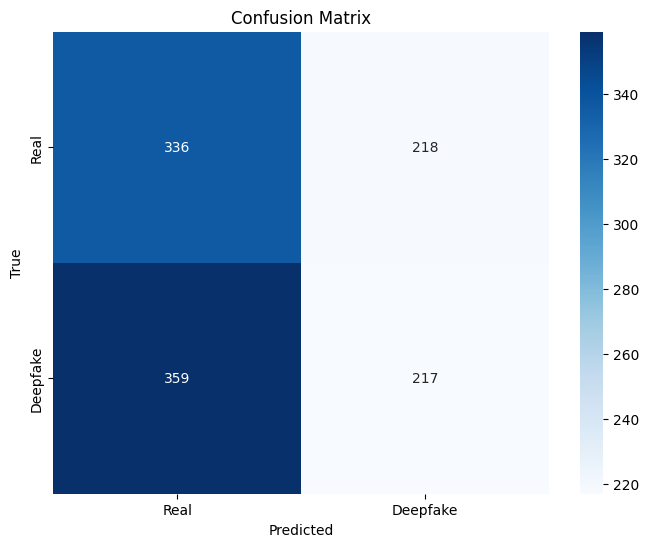

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Deepfake'], yticklabels=['Real', 'Deepfake'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [23]:
report = classification_report(true_labels, predictions, target_names=['Real', 'Deepfake'])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

        Real       0.48      0.61      0.54       554
    Deepfake       0.50      0.38      0.43       576

    accuracy                           0.49      1130
   macro avg       0.49      0.49      0.48      1130
weighted avg       0.49      0.49      0.48      1130



test

In [24]:
test_generator.reset()
predictions = (model0.predict(test_generator) > 0.5).astype(int).flatten()
true_labels = test_generator.classes

36/36 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step


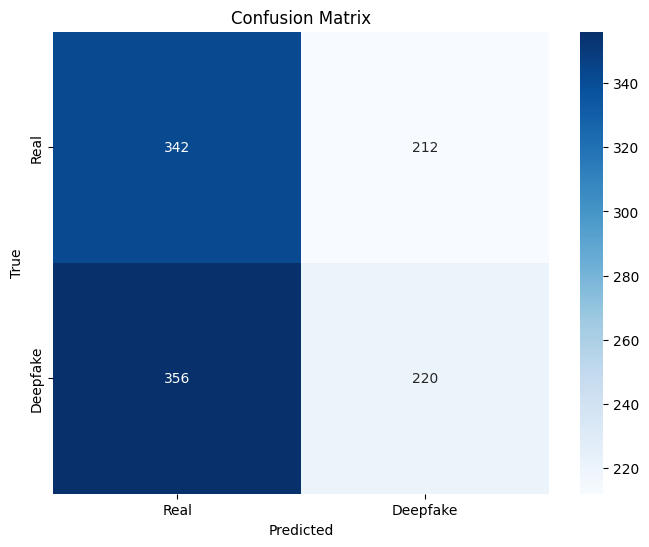

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Deepfake'], yticklabels=['Real', 'Deepfake'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [26]:
report = classification_report(true_labels, predictions, target_names=['Real', 'Deepfake'])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

        Real       0.49      0.62      0.55       554
    Deepfake       0.51      0.38      0.44       576

    accuracy                           0.50      1130
   macro avg       0.50      0.50      0.49      1130
weighted avg       0.50      0.50      0.49      1130



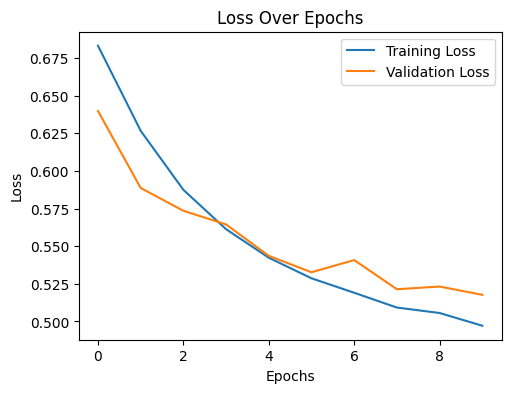

In [27]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

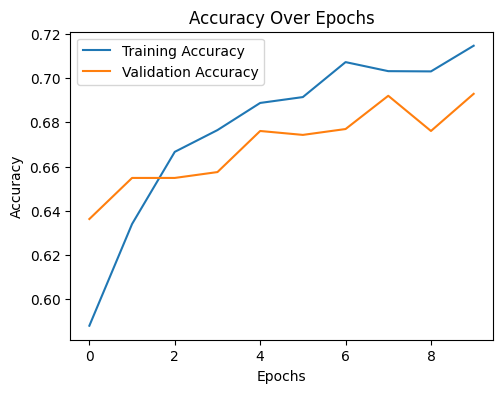

In [28]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()